# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy
from torchvision import transforms, models

get_dataset.py приходится подгружать в рабочую директорию руками(

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
data.shape

(13143, 45, 45, 3)

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

Реализуем случайное разбиение датасета

In [ ]:
ix = np.random.choice(len(data), len(data), False)
tr, val = np.split(ix, [TRAIN_SIZE])

In [ ]:
tr

array([10200, 10132,  5979, ...,  6651, 12100,  6317])

In [ ]:

X_train = data[tr]
X_val = data[val]

In [ ]:
X_train.shape

(10000, 45, 45, 3)

Функция отрисовки **n_row ⋅ n_co**l первых картинок в массиве **images**

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

Проверим нашу функцию

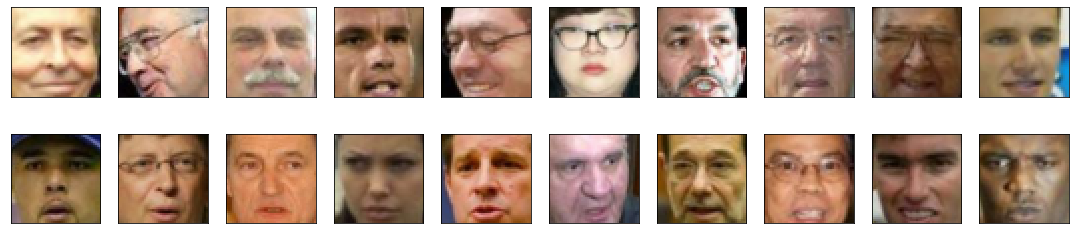

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W, n_row=2, n_col=10)

Создадим теперь списки тензоров для подачи в даталодер

In [ ]:
x_train = []
x_val = []


In [ ]:
for i in range(TRAIN_SIZE):
  x_train.append(transforms.ToTensor()(X_train[i]))
  x_train[i] = x_train[i].float()

for i in range(VAL_SIZE):
  x_val.append(transforms.ToTensor()(X_val[i]))
  x_val[i] = x_val[i].float()
    

In [ ]:
x_train[0].shape

torch.Size([3, 45, 45])

И скормим даталодеру

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(x_train, batch_size=batch_size, shuffle=True)
data_val = DataLoader(x_val, batch_size=batch_size, shuffle=True)

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

In [ ]:
dim_code = 100 # выберите размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

Обозначим размер входной картинки

In [ ]:
inp_size=X_train.shape[1]

In [ ]:
inp_size

45

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

С линейными слоями

In [ ]:
from copy import deepcopy
class AutoencoderLinear(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_linear_1 = nn.Linear(11 * 11 * 20, 200)
      self.enc_linear_2 = nn.Linear(200, dim_code)
      


      self.dec_linear_1 = nn.Linear(dim_code, 11 * 11 * 20)
      self.dec_linear_2 = nn.Linear(11 * 11 * 20, 45 * 45 * 3)
      #  <определите архитектуры encoder и decoder>
        
    def forward(self, x):
      latent_code = self.encode(x)
      reconstruction = self.decode(latent_code)

      #  <реализуйте forward проход автоэнкодера
      #  в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
      #  и полученная реконструкция изображения (reconstruction)>
        
      return reconstruction, latent_code
    
    def encode(self, images):
      code = self.enc_cnn_1(images) # 10,45,45
      code = F.relu(F.max_pool2d(code, 2)) # 10,22,22
      code = self.enc_cnn_2(code)  # 20,22,22
      code = F.relu(F.max_pool2d(code, 2)) # 20,11,11

      code = code.view([-1, 11 * 11 * 20])
      code = F.relu(self.enc_linear_1(code))
      code = F.sigmoid(self.enc_linear_2(code))
      return code

    def decode(self, code):
      out = F.relu(self.dec_linear_1(code))
      out = F.sigmoid(self.dec_linear_2(out))
      out = out.view([-1, 3, 45, 45])
      return out

Со сверточными слоями

In [ ]:
from copy import deepcopy
class AutoencoderConv(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_cnn_3 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=3, padding=1) # 50 * 10 * 10
      
      self.enc_linear_1 = nn.Linear(50 * 5 * 5, 11 * 11 * 20)
      self.enc_linear_2 = nn.Linear(11 * 11 * 20, 200)
      self.enc_linear_3 = nn.Linear(200, dim_code)
      
      
      self.dec_linear_1 = nn.Linear(dim_code, 11 * 11 * 20)
      self.dec_linear_2 = nn.Linear(11 * 11 * 20, 50 * 5 * 5)
      
      self.dec_cnn_1 = nn.ConvTranspose2d(in_channels = 50 , out_channels = 20, kernel_size = 3, stride = 2) #20 * 11 * 11
      self.dec_cnn_2 = nn.ConvTranspose2d(in_channels = 20 , out_channels = 10, kernel_size = 2, stride = 2) #10 * 22 * 22
      self.dec_cnn_3 = nn.ConvTranspose2d(in_channels = 10 , out_channels = 3, kernel_size = 3, stride = 2) #3 * 45 * 45
      
    
      #  <определите архитектуры encoder и decoder>

    def forward(self, x):
      latent_code = self.encode(x)
      reconstruction = self.decode(latent_code)

      #  <реализуйте forward проход автоэнкодера
      #  в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
      #  и полученная реконструкция изображения (reconstruction)>
        
      return reconstruction, latent_code
    
    def encode(self, images):
      code = self.enc_cnn_1(images) # 10,45,45
      code = F.relu(F.max_pool2d(code, 2)) # 10,22,22

      code = self.enc_cnn_2(code)  # 20,22,22
      code = F.relu(F.max_pool2d(code, 2)) # 20,11,11

      code = self.enc_cnn_3(code)  # 50,10,10
      code = F.relu(F.max_pool2d(code, 2)) # 50,5,5


      code = code.view([-1, 50 * 5 * 5])
      code = code.view([-1, 50 * 5 * 5])
      code = F.relu(self.enc_linear_1(code))
      code = F.relu(self.enc_linear_2(code))
      code = (self.enc_linear_3(code))
      return code

    def decode(self, code):
      
      out = F.relu(self.dec_linear_1(code)) # 11 * 11 * 20
      out = F.relu(self.dec_linear_2(out))

      out = out.view([-1, 50, 5, 5]) 

      
      out = F.relu(self.dec_cnn_1(out))
      out = F.relu(self.dec_cnn_2(out))  #10 * 22 * 22


      out = F.sigmoid(self.dec_cnn_3(out))
      return out

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
criterion = nn.MSELoss()

autoencoder = AutoencoderConv().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

n_epochs = 40

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.019281,	val Loss: 0.012583 
Epoch: 2 	Training Loss: 0.011619,	val Loss: 0.010710 
Epoch: 3 	Training Loss: 0.010228,	val Loss: 0.009769 
Epoch: 4 	Training Loss: 0.009298,	val Loss: 0.009176 
Epoch: 5 	Training Loss: 0.008695,	val Loss: 0.008463 
Epoch: 6 	Training Loss: 0.008065,	val Loss: 0.007798 
Epoch: 7 	Training Loss: 0.007669,	val Loss: 0.007526 
Epoch: 8 	Training Loss: 0.007302,	val Loss: 0.007331 
Epoch: 9 	Training Loss: 0.007016,	val Loss: 0.007036 
Epoch: 10 	Training Loss: 0.006715,	val Loss: 0.006881 
Epoch: 11 	Training Loss: 0.006533,	val Loss: 0.006725 
Epoch: 12 	Training Loss: 0.006346,	val Loss: 0.006565 
Epoch: 13 	Training Loss: 0.006233,	val Loss: 0.006409 
Epoch: 14 	Training Loss: 0.006108,	val Loss: 0.006549 
Epoch: 15 	Training Loss: 0.005972,	val Loss: 0.006270 
Epoch: 16 	Training Loss: 0.005812,	val Loss: 0.006160 
Epoch: 17 	Training Loss: 0.005657,	val Loss: 0.006024 
Epoch: 18 	Training Loss: 0.005546,	val Loss: 0.006036 
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch: 21 	Training Loss: 0.005283,	val Loss: 0.005696 
Epoch: 22 	Training Loss: 0.005158,	val Loss: 0.005734 
Epoch: 23 	Training Loss: 0.005070,	val Loss: 0.005615 
Epoch: 24 	Training Loss: 0.004984,	val Loss: 0.005613 
Epoch: 25 	Training Loss: 0.004911,	val Loss: 0.005539 
Epoch: 26 	Training Loss: 0.004869,	val Loss: 0.005644 
Epoch: 27 	Training Loss: 0.004783,	val Loss: 0.005569 
Epoch: 28 	Training Loss: 0.004742,	val Loss: 0.005525 
Epoch: 29 	Training Loss: 0.004674,	val Loss: 0.005453 
Epoch: 30 	Training Loss: 0.004635,	val Loss: 0.005414 
Epoch: 31 	Training Loss: 0.004602,	val Loss: 0.005862 
Epoch: 32 	Training Loss: 0.004539,	val Loss: 0.005446 
Epoch: 33 	Training Loss: 0.004470,	val Loss: 0.005373 
Epoch: 34 	Training Loss: 0.004445,	val Loss: 0.005400 
Epoch: 35 	Training Loss: 0.004389,	val Loss: 0.005422 
Epoch: 36 	Training Loss: 0.004347,	val Loss: 0.005393 
Epoch: 37 	Training Loss: 0.004316,	val Loss: 0.005511 
Epoch: 38 	Training Loss: 0.004280,	val Loss: 0.

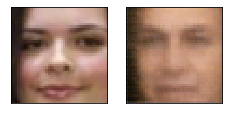

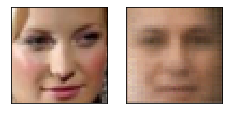

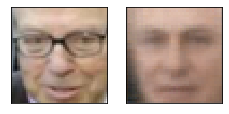

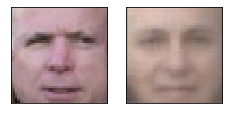

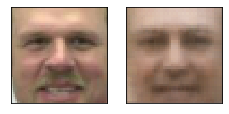

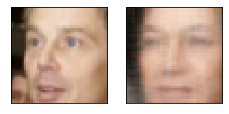

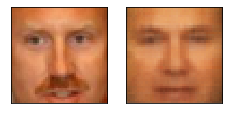

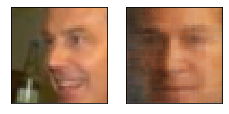

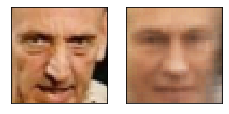

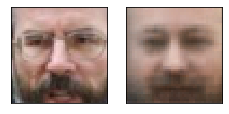

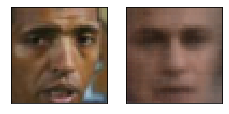

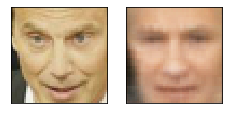

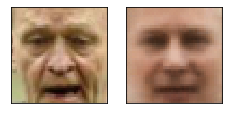

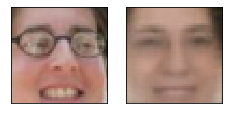

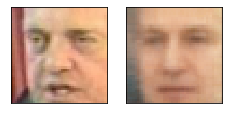

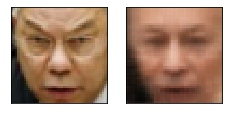

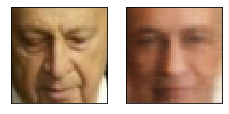

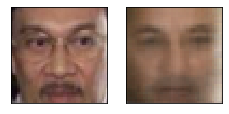

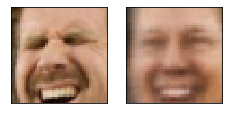

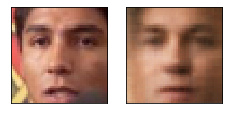

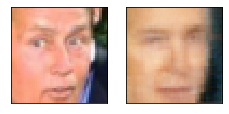

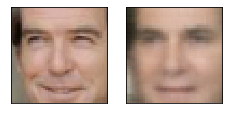

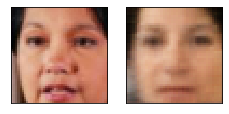

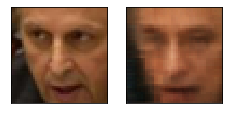

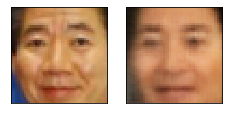

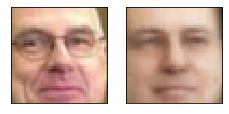

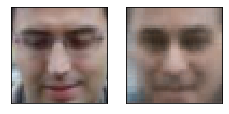

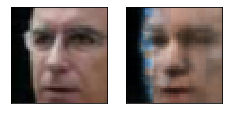

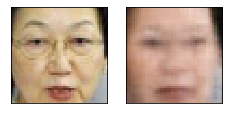

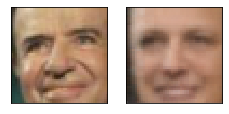

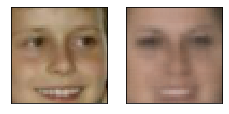

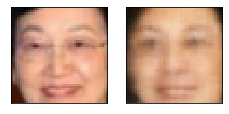

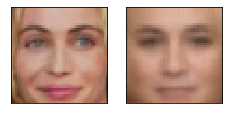

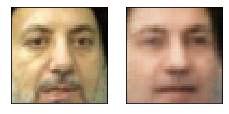

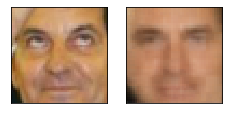

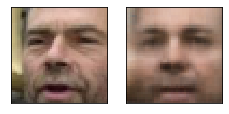

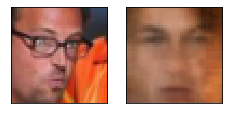

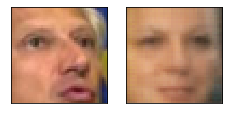

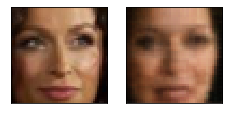

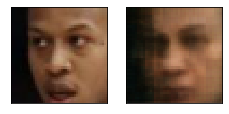

In [ ]:
history_train = []
history_val = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    ###################
    # train the model #
    ###################
    for images in data_tr:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images)
        # calculate the loss
        loss = criterion(reconstruction, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.cpu().detach().numpy()
    #plot_gallery([images[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        
    #print avg training statistics 

    train_loss = train_loss/len(data_tr)
    history_train.append(train_loss)
    
    for images in data_val:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images)
        # calculate the loss
        loss = criterion(reconstruction, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        val_loss += loss.cpu().detach().numpy()

    val_loss = val_loss/len(data_val)
    history_val.append(val_loss)
    
    plot_gallery([images[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        ))


Посмотрим на графики лоссов

In [ ]:
epochs = np.linspace(1,30,30)

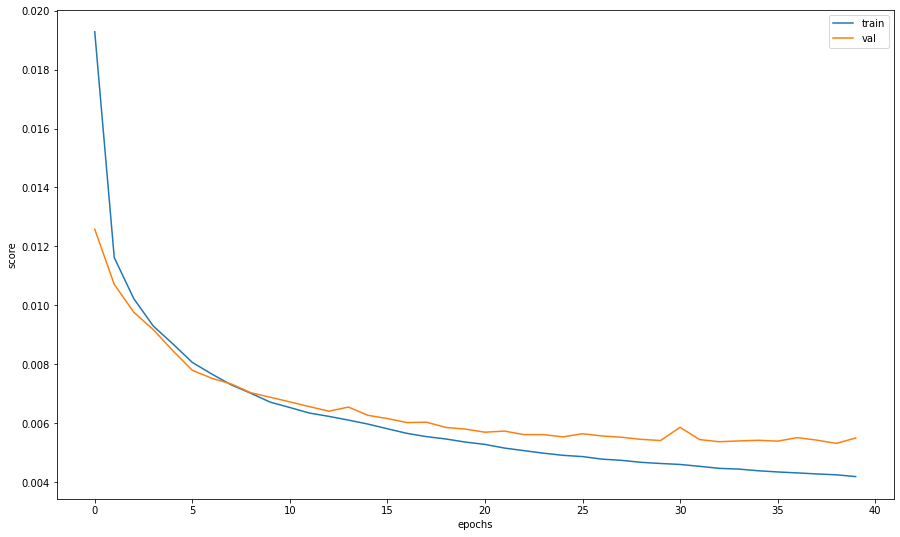

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(history_train, label="train")
plt.plot(history_val, label="val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
for images in data_val:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images)
        break;

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

In [ ]:
b = images.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

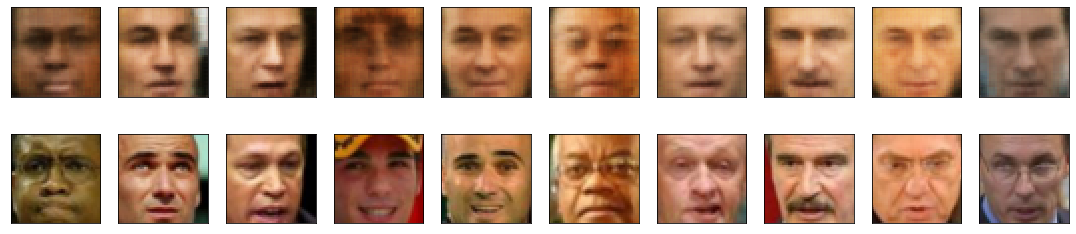

In [ ]:
plot_gallery(np.concatenate((a,b), axis=0), IMAGE_H, IMAGE_W, n_row=2, n_col=10)        

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


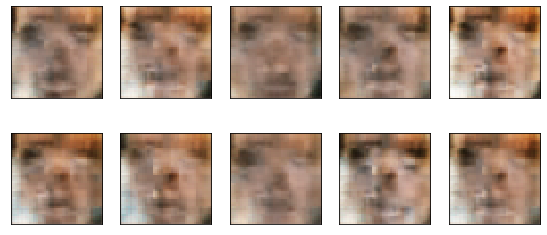

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.rand(10,100).to(device)
output = autoencoder.decode(z)
plot_gallery(output.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!



Разобьем датафрейм атрибутов на train и val

In [ ]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [ ]:
attrs_tr = attrs.iloc[tr]
attrs_val = attrs.iloc[val]

In [ ]:
attrs_tr.head(30)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
10200,-0.684525,-1.35215,0.735758,-0.839155,-2.99973,-1.58746,-1.09319,-0.250376,0.282509,-1.50847,-0.752791,-0.223314,-1.17354,0.996098,-0.415364,-1.72889,-1.5871,0.798912,-1.24927,0.128715,0.135887,0.799285,-1.02509,-0.320749,0.441841,0.874678,0.750744,-0.919176,0.707879,-1.2575,-0.562539,0.305174,-0.661034,-1.02429,-0.409231,-0.766257,1.5001,0.483438,0.524821,-0.079707,-0.113678,0.631554,-0.200065,-1.74319,-0.624029,1.22741,-1.2899,0.104564,0.2171,0.122109,-0.751383,-0.64898,-0.555751,1.77269,0.578331,-0.866531,-1.13454,-0.864233,-0.195051,1.11079,-0.841024,-2.58074,-1.68868,1.58276,-2.21541,1.72364,-0.262472,-4.71579,1.4157,0.596388,0.0484771,0.832366,-0.152708
10132,0.126784,-0.167021,-0.562646,-1.51232,-0.565508,0.341361,-1.02403,-0.787377,-0.74231,-1.53288,-0.490677,-0.888579,-0.391676,-0.764545,0.111012,-0.68555,0.336304,-0.0599822,-0.165585,-0.989462,-0.0445065,-0.212767,-0.83524,0.318001,0.348974,0.373479,-0.0856056,-0.363255,0.651722,-0.297917,-0.282754,-1.37198,0.0139225,-0.569387,0.336499,0.97641,0.203599,-0.204656,0.108335,0.235703,0.206984,1.18632,-0.884712,-0.914748,0.119439,-1.04314,-0.408732,0.348245,-0.539774,-0.251463,-0.626615,-0.626963,-0.348189,3.13114,-0.755072,-0.226372,0.331689,-0.640728,-0.665558,0.148411,-0.575686,-0.0907513,-0.551202,1.90126,-0.401908,-0.235344,0.048961,-4.01775,-1.03031,0.94208,-0.463031,-0.590577,0.0504296
5979,2.57584,-1.49691,1.08054,-2.30088,-2.10802,-1.52678,-0.694088,-0.104073,0.00400997,-2.12206,-1.29889,-1.07861,-0.233683,0.115357,-1.58007,-0.863514,0.802721,-1.11959,1.06807,0.652412,-0.394276,-0.607069,-0.808633,0.45687,-0.0649303,0.169868,1.08775,-0.49328,1.06491,-0.887891,0.193696,0.620748,-0.631205,-0.678493,0.616405,-0.430456,1.62032,0.230312,0.440651,0.478643,0.17948,0.621493,-0.6872,-1.18854,0.739145,-1.19244,0.107575,0.056676,-0.0353927,-0.39645,-0.0731967,-0.0936609,-0.541398,0.415091,0.243382,-0.0658078,-0.808823,-1.2991,0.356466,0.857108,-0.821957,-0.990059,-0.990753,2.3958,1.19226,-0.0939652,-1.70211,-4.14089,-0.592412,-0.400086,-1.08683,0.651472,-1.37079
12990,1.11138,-0.96939,-0.167495,-0.541561,-1.5894,-0.431068,-0.526065,-0.413988,-0.955274,-1.2197,-0.420466,-0.705321,0.041232,0.463685,-1.55593,-1.00707,0.0723977,-0.426742,0.299516,0.360125,-1.02198,-0.8286,-1.29609,0.95035,0.780959,0.0536746,0.204658,-0.89205,0.115407,-0.0639636,0.219914,0.875554,-0.510509,-0.119994,0.952187,-0.391471,-0.354966,1.30368,-0.104969,0.17466,0.000745013,-2.41139,0.50432,-0.346135,-0.631092,-0.469091,-0.373007,0.308539,-0.0305858,0.099951,0.268435,-0.281383,-0.567672,2.5017,-0.426887,0.141538,-0.764653,-1.23969,-0.717425,-0.401316,-0.825093,-1.3903,-1.16122,-0.526192,0.546522,-0.945108,-1.44246,-2.56479,-1.43412,1.52603,-1.22147,-0.684192,-0.915708
198,0.134658,-0.228607,-0.952063,-0.819621,-1.62607,-1.42883,0.413805,-0.641264,-0.474127,-0.113208,-0.956672,-1.36928,0.0761083,-0.237274,0.790037,-1.18109,-0.593398,0.432969,-0.724767,-0.346483,0.27163,-0.780964,-0.557213,-0.292578,0.0720855,-0.31584,0.077717,2.00665,1.11182,-0.770638,-0.0479061,-1.01131,0.224947,-0.499574,0.498773,-0.794775,1.06153,-0.633677,0.82306,-0.294204,-0

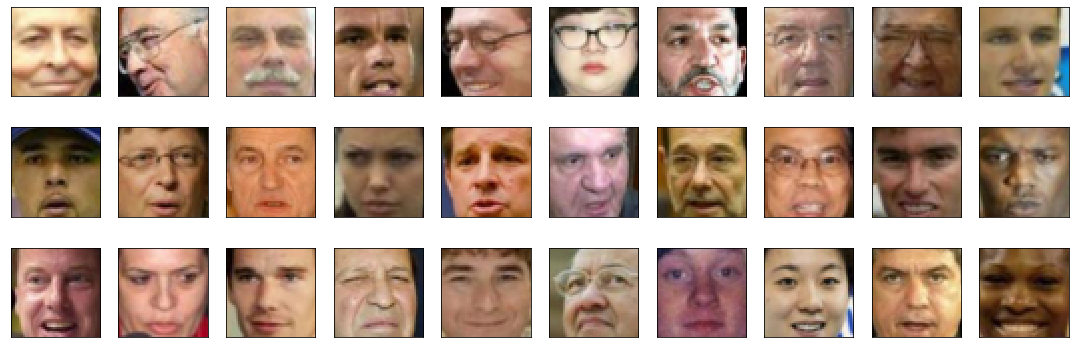

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W, n_row=3, n_col=10)

In [ ]:
SAD = []
SMILE = []

In [ ]:
k = -1
for i in tr[:200]:
  k += 1
  if (attrs.loc[i]['Smiling'] > 1.5):
    SMILE.append(X_train[k])
  elif (attrs.loc[i]['Smiling'] < -1):
    SAD.append(X_train[k])
    print(i, attrs.loc[i]['Smiling'])

5979 -1.11959090954
8219 -1.39011939988
5858 -1.7688102319699999
1258 -1.08607721223
3659 -2.26787659341
664 -1.31998750811
9850 -1.1875748686499998
11576 -1.6624216046399998
3502 -1.13841239042
5665 -1.31899299124
6310 -1.6769670118
4225 -1.38342618598
10673 -2.1829055571400002
2460 -1.0617198103299998
10312 -1.74750975883
6546 -1.9238432737200002
10705 -2.2458714457199997
4630 -1.90763249185
4362 -1.64324779625
5864 -1.30806106104
10300 -1.06613629335
7629 -1.0409602951299999
5879 -1.18453561403
1190 -1.3505735635799998
6656 -1.7397317991799999
4863 -1.68152451815
6761 -1.14241586412
5625 -1.2232040562200002
11267 -1.5337820948899998
12502 -1.1773975272200001
10104 -2.1672274539
82 -1.9520597345099997
12249 -1.39126298806
9877 -1.26487206944
2315 -1.33718168526
1033 -1.39060613247
407 -1.49344552623
12278 -1.5822964342399999
1020 -1.03381210533
4835 -1.3607566173299999
2578 -1.8192243915200002
7135 -1.24604751598
4721 -1.2897701475299999
1512 -1.41207426856
515 -1.64972113226
2963 -1

In [ ]:
len(SAD)

62

In [ ]:
len(SMILE)

18

In [ ]:
lenlist = min(len(SMILE), len(SAD))
SMILE = SMILE[:lenlist]
SAD = SAD[:lenlist]

Посмотрим, какие картинки мы выбрали

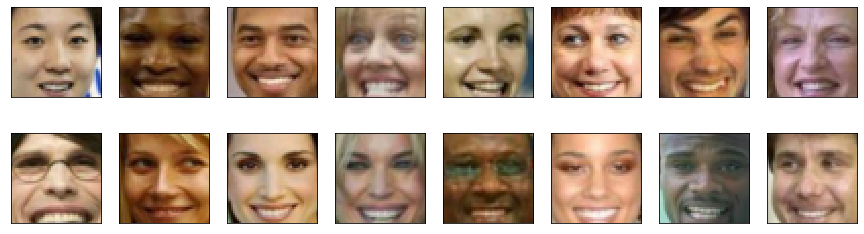

In [ ]:
plot_gallery(SMILE, IMAGE_H, IMAGE_W, n_row=2, n_col=8)

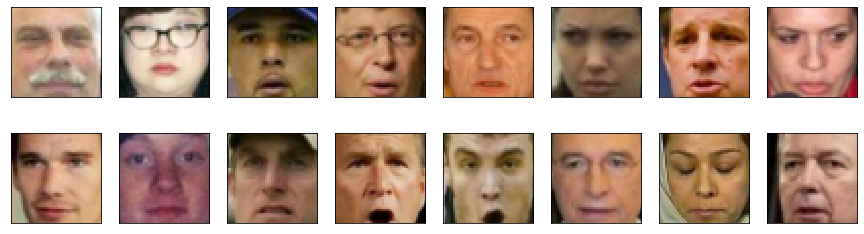

In [ ]:
plot_gallery(SAD, IMAGE_H, IMAGE_W, n_row=2, n_col=8)

In [ ]:
SMILE_TENSOR  = torch.Tensor(lenlist,3,45,45)
SAD_TENSOR = torch.Tensor(lenlist,3,45,45)
for i in range (lenlist):
  SMILE_TENSOR[i] = transforms.ToTensor()(SMILE[i]).float()
  SAD_TENSOR[i] = transforms.ToTensor()(SAD[i]).float()

In [ ]:
SMILE_TENSOR = SMILE_TENSOR.to(device)
SAD_TENSOR = SAD_TENSOR.to(device)

In [ ]:
SMILE_VECTOR = autoencoder.encode(SMILE_TENSOR)
SAD_VECTOR = autoencoder.encode(SAD_TENSOR)

In [ ]:
VECTOR =  SMILE_VECTOR.mean(axis=0) - SAD_VECTOR.mean(axis=0)

In [ ]:
reconstruction, latent_code = autoencoder(images)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
latent_code = latent_code + VECTOR
latent_code = latent_code.to(device)

In [ ]:
images_smile = autoencoder.decode(latent_code)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
d = images_smile.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

Посмотрим, как получилось:

До

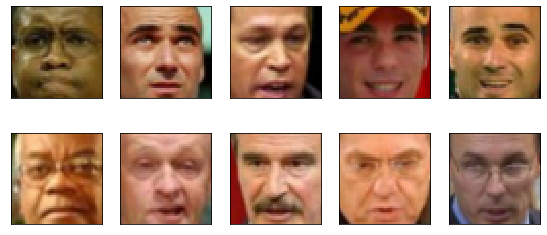

In [ ]:
plot_gallery(b, IMAGE_H, IMAGE_W, n_row=2, n_col=5)        

После

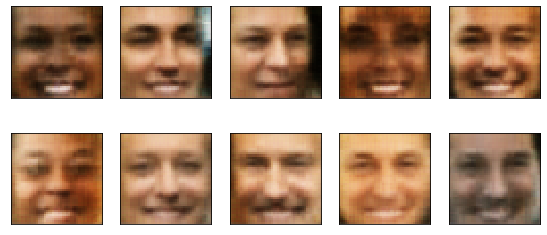

In [ ]:
plot_gallery(d, IMAGE_H, IMAGE_W, n_row=2, n_col=5)        

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

Подготовим датасет

In [ ]:
import torchvision
from torchvision import datasets, transforms
dataset_train = datasets.MNIST(root='MNIST',
                               train=True,
                               transform = transforms.ToTensor(),
                               download=True)
dataset_test  = datasets.MNIST(root='MNIST', 
                               train=False, 
                               transform = transforms.ToTensor(),
                               download=True)
batch_size = 128
num_workers = 2
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size = batch_size,
                                               shuffle=True,
                                               num_workers = num_workers, 
                                               pin_memory=True)

dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                               batch_size = batch_size,
                                               num_workers = num_workers,
                                               pin_memory=True)


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw




Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw
Processing...
Done!


Функция для отрисовки MNISTа:

In [ ]:
def plot_gallery_MNIST(dataset, h = 28, w = 28, n_row=3, n_col=6):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(dataset[i].numpy().squeeze(), cmap='gray', vmin=-1, vmax=1)
            plt.xticks(())
            plt.yticks(())
        except:
            pass

Построим архитектуру нашей сети

Используем увеличенное количество слоев и сверточные слои в декодере, чтобы получить приемлемое качество


In [ ]:
dim_code = 100

In [ ]:
from copy import deepcopy
class VAE(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_cnn_3 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=2, padding=1)
      
      self.enc_linear_1 = nn.Linear(50 * 4 * 4, 7 * 7 * 20)
      self.enc_linear_2 = nn.Linear(7 * 7 * 20, 200)
      
      self.enc_linear_3_mu = nn.Linear(200, dim_code)
      self.enc_linear_3_logsigma = nn.Linear(200, dim_code)
      
      
      self.dec_linear_1 = nn.Linear(dim_code, 7 * 7 * 20)
      self.dec_linear_2 = nn.Linear(7 * 7 * 20, 50 * 4 * 4)
      
      self.dec_cnn_1 = nn.ConvTranspose2d(in_channels = 50 , out_channels = 20, kernel_size = 3, stride = 1)
      self.dec_cnn_2 = nn.ConvTranspose2d(in_channels = 20 , out_channels = 10, kernel_size = 3, stride = 2)
      self.dec_cnn_3 = nn.ConvTranspose2d(in_channels = 10 , out_channels = 1, kernel_size = 4, stride = 2)


    
    def encode(self, images):
      #print('Вход в енкодер', images.shape)
      code = self.enc_cnn_1(images)
      
      code = F.relu(F.max_pool2d(code, 2))
      #print('Первый слой', code.shape)
      code = self.enc_cnn_2(code)
      code = F.relu(F.max_pool2d(code, 2))
      #print('Второй слой', code.shape)
      code = self.enc_cnn_3(code)
      code = F.relu(F.max_pool2d(code, 2))
      #print('Третий слой', code.shape)

      code = code.view([-1, 50 * 4 * 4])
      code = code.view([-1, 50 * 4 * 4])
      code = F.relu(self.enc_linear_1(code))
      code = F.relu(self.enc_linear_2(code))


      mu = self.enc_linear_3_mu(code)
      logsigma = self.enc_linear_3_logsigma(code) 

      return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, code):
      #print('Вход в декодер', images.shape)
      out = F.relu(self.dec_linear_1(code))
      out = F.relu(self.dec_linear_2(out))
      out = out.view([-1, 50, 4, 4]) 
      #print('После view', out.shape)
      
      out = F.relu(self.dec_cnn_1(out))
      #print('После первого слоя', out.shape)
      out = F.relu(self.dec_cnn_2(out))
      #print('После второго слоя', out.shape)
      out = F.sigmoid(self.dec_cnn_3(out))
      #print('После третьего слоя', out.shape)
      return out

    def forward(self, x):
      mu, logsigma = self.encode(x)
      reconstruction = self.gaussian_sampler(mu, logsigma)
      reconstruction = self.decode(reconstruction)


      return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = (-0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())) / (28 * 28)
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x)
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    #print(KL_divergence(mu, logsigma), log_likelihood(x, reconstruction))
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Теперь обучим модель:

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
criterion = loss_vae

VAE_autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(VAE_autoencoder.parameters(), lr=0.001)

In [ ]:
n_epochs = 50
history_train_1 = []
history_val_1 = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    ###################
    # train the model #
    ###################
    for images, labels in dataloader_train:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, logsigma, reconstruction = VAE_autoencoder(images)

        # calculate the loss
        loss = criterion(images, mu, logsigma, reconstruction)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.cpu().detach().numpy()
    #plot_gallery([images[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        
    #print avg training statistics 
    train_loss = train_loss/len(dataloader_train)
    history_train_1.append(train_loss)
    
    for images, labels in dataloader_test:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, logsigma, reconstruction = VAE_autoencoder(images)
        # calculate the loss
        loss = criterion(images, mu, logsigma, reconstruction)
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        val_loss += loss.cpu().detach().numpy()

    #plot_gallery_MNIST(images.to("cpu"), 28, 28, n_row=1, n_col=5)
    #plot_gallery_MNIST(reconstruction.to("cpu").detach(), 28, 28, n_row=1, n_col=5)   
    val_loss = val_loss/len(dataloader_test)
    history_val_1.append(val_loss)
    
    #plot_gallery_MNIST([images.to("cpu").clone().detach().numpy().squeeze(), reconstruction[0].to("cpu").clone().detach().numpy().squeeze()], 28, 28, 1, 2)       

    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        )) 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.371866,	val Loss: 0.337595 
Epoch: 2 	Training Loss: 0.245554,	val Loss: 0.220155 
Epoch: 3 	Training Loss: 0.201981,	val Loss: 0.174622 
Epoch: 4 	Training Loss: 0.164950,	val Loss: 0.147692 
Epoch: 5 	Training Loss: 0.138729,	val Loss: 0.128276 
Epoch: 6 	Training Loss: 0.123228,	val Loss: 0.117102 
Epoch: 7 	Training Loss: 0.114477,	val Loss: 0.109062 
Epoch: 8 	Training Loss: 0.108474,	val Loss: 0.104916 
Epoch: 9 	Training Loss: 0.104059,	val Loss: 0.100327 
Epoch: 10 	Training Loss: 0.100663,	val Loss: 0.098531 
Epoch: 11 	Training Loss: 0.097625,	val Loss: 0.094969 
Epoch: 12 	Training Loss: 0.095566,	val Loss: 0.092531 
Epoch: 13 	Training Loss: 0.093940,	val Loss: 0.092119 
Epoch: 14 	Training Loss: 0.092495,	val Loss: 0.090751 
Epoch: 15 	Training Loss: 0.091431,	val Loss: 0.089456 
Epoch: 16 	Training Loss: 0.090250,	val Loss: 0.088884 
Epoch: 17 	Training Loss: 0.089240,	val Loss: 0.089008 
Epoch: 18 	Training Loss: 0.088494,	val Loss: 0.086481 
E

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
for images, labels in dataloader_test:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, logsigma, reconstruction = VAE_autoencoder(images)
        break;

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
a = reconstruction.to("cpu").detach()

In [ ]:
b = images.to("cpu")

In [ ]:
a.shape

torch.Size([128, 1, 28, 28])

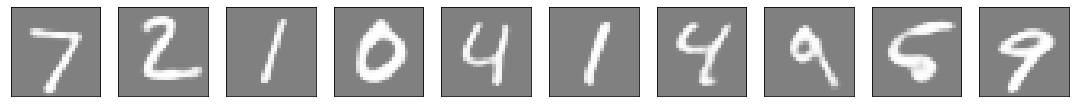

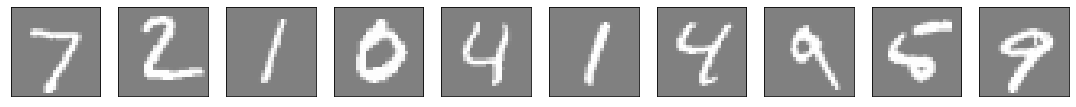

In [ ]:
plot_gallery_MNIST(a, 28, 28, n_row=1, n_col=10)
plot_gallery_MNIST(b, 28, 28, n_row=1, n_col=10)   

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


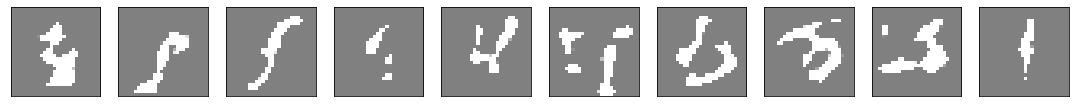

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = VAE_autoencoder.decode(((torch.from_numpy(z)).to(device)).float())

plot_gallery_MNIST(output.to("cpu").detach(), 28, 28, 1, 10)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
lentest = len(dataset_test)

In [ ]:
numbers = []
for i in range(lentest):
  numbers.append(dataset_test[i][1])

In [ ]:
data_visualization = torch.utils.data.DataLoader(dataset_test, 10, shuffle=False)

In [ ]:
latent_vectors=[]
for images, labels in data_visualization:
  images = images.to(device)
  mu, logsigma, reconstruction = VAE_autoencoder(images)
  latent = VAE_autoencoder.gaussian_sampler(mu, logsigma)
  latent_vectors.append(latent.data.cpu().numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
latent_vectors[0].shape

(10, 100)

In [ ]:
final_vectors = []
for vec in latent_vectors:
  for i in range(10):
    final_vectors.append(vec[i])

In [ ]:
from sklearn.manifold import TSNE
Emb = TSNE(n_components=2).fit_transform(final_vectors)

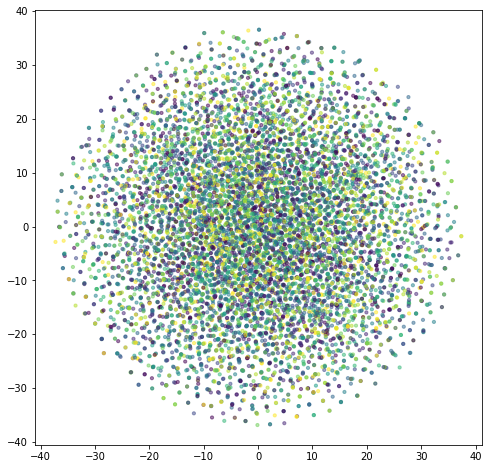

In [ ]:
fig, ax = plt.subplots()
ax.scatter(Emb[:,0], Emb[:,1], s=10, alpha=0.5, c = numbers)
fig.set_figwidth(8)
fig.set_figheight(8)

Что вы думаете о виде латентного представления?

Вроде все хорошо) Похоже на нормальное.

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): 
       
        inputs = torch.cat([x, c], 1) 
        h1 = self.relu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std) + mu
        else:
            return mu

    def decode(self, z, c): 
     
        inputs = torch.cat([z, c], 1) 
        h3 = self.relu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.reparametrize(mu, logvar)
        return self.decode(z, c), mu, logvar

Заново загрузим MNIST, чтобы можно было регулировать batchsize, не меняя его для VAE

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torchvision
from torchvision import datasets, transforms

batch_size = 32
latent_size = 20

kwargs = {'num_workers': 1, 'pin_memory': True}
dataloader_train2 = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
dataloader_test2 = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
def train(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(dataloader_train2):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader_train2.dataset),
                100. * batch_idx / len(dataloader_train2),
                loss.data / len(data)))

def test(model, epoch):
    model.eval()
    test_loss = 0
    for i, (data, labels) in enumerate(dataloader_test2):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        test_loss += loss_function(recon_batch, data, mu, logvar)
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
            #save_image(comparison.data.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(dataloader_test2.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
def to_var(x):
    x = Variable(x).to(device)
    return x

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return to_var(targets)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
CVAE_autoencoder = CVAE(28 * 28, latent_size, 10).to(device)
optimizer = optim.Adam(CVAE_autoencoder.parameters(), lr=1e-3)

In [ ]:
for epoch in range(1, 20):
    train(CVAE_autoencoder, epoch)
    test(CVAE_autoencoder, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.127215
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.006881
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.006900
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.006759
====> Test set loss: 0.0071
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.007496
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.006793
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.006704
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.007071
====> Test set loss: 0.0069
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007036
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.006558
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.007209
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.006732
====> Test set loss: 0.0069
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.007303
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.007120
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.007383
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.006925
====> Test set loss: 0.0069
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.006939
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.006385
Train Epoch: 

In [ ]:
for images, labels in dataloader_test2:
        # _ stands in for labels, here
        # no need to flatten images
        images = to_var(images)
        labels = (one_hot(labels, 10))
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, mu, logvar = CVAE_autoencoder(images, labels)
        break;

In [ ]:
a = reconstruction.to("cpu").detach().squeeze().reshape(32, 1, 28, 28)

In [ ]:
a.shape

torch.Size([32, 1, 28, 28])

In [ ]:
b = images.to("cpu")

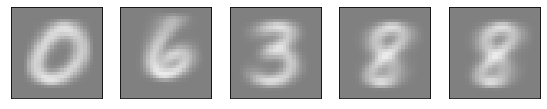

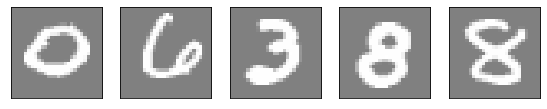

In [ ]:
plot_gallery_MNIST(a, 28, 28, 1, 5)
plot_gallery_MNIST(b, 28, 28, 1, 5)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

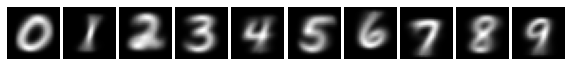

In [ ]:
import matplotlib.gridspec as gridspec

c = torch.eye(10, 10)
c = to_var(c)
z = to_var(torch.randn(10, latent_size))
samples = CVAE_autoencoder.decode(z, c).data.cpu().numpy()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='gray')

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
latent_vectors2=[]
numbers2=[]

In [ ]:
for batch_idx, (data, labels) in enumerate(dataloader_train2):
        data = to_var(data)
        numbers2.append(labels.data.cpu().numpy())
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = CVAE_autoencoder(data, labels)
        z = CVAE_autoencoder.reparametrize(mu, logvar)
        latent_vectors2.append(z.data.cpu().numpy())
   

In [ ]:
numbers_final = []
final_vectors2 = []

In [ ]:
for vec in numbers2:
  for i in range(vec.shape[0]):
    numbers_final.append(vec[i])

for vec in latent_vectors2:
  for i in range(vec.shape[0]):
    final_vectors2.append(vec[i])


In [ ]:
numbers_final = numbers_final[:10000]
final_vectors2 = final_vectors2[:10000]

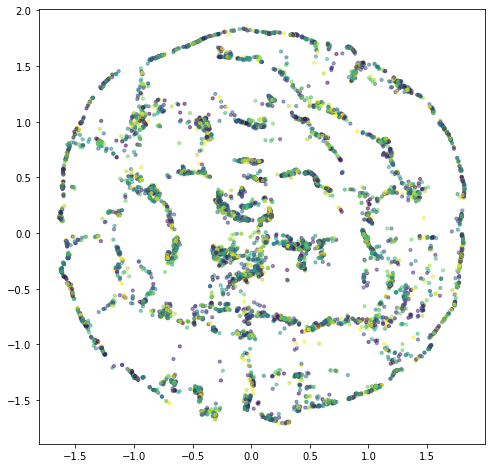

In [ ]:
from sklearn.manifold import TSNE
emb = TSNE(n_components=2).fit_transform(final_vectors2)
fig, ax = plt.subplots()
ax.scatter(emb[:,0], emb[:,1], s=10, alpha=0.5,c = numbers_final)
fig.set_figwidth(8)
fig.set_figheight(8)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Она разбита по кластерам, ввиду структуры CVAE

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
for images in data_tr:
  images = images.to(device)
  reconstruction, latent_code = autoencoder(images)
  break;
IMG_1 = images[0]
IMG_2 = images[3]
VEC_1 = latent_code[0]
VEC_2 = latent_code[3]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
arr = torch.Tensor(11,100)
for i in range(11):
  arr[i] = ((i * 0.1) * VEC_1 + (1 - i * 0.1) * VEC_2)
arr = arr.to(device)

In [ ]:
Arr_Pictures = autoencoder.decode(arr)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


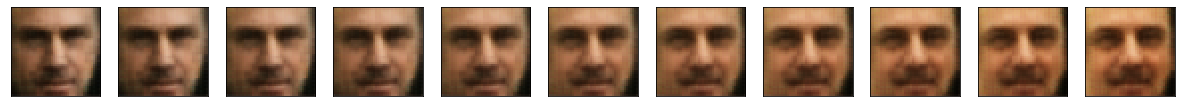

In [ ]:
Arr_Pictures_final = Arr_Pictures.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
plot_gallery(Arr_Pictures_final, IMAGE_H, IMAGE_W, n_row=1, n_col=11)    

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

Вспомогательная функция

In [213]:
def convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  
  image = image.clip(0, 1)
  
  return image

In [238]:
def get_nois(image):
  noise_factor = 0.2
  X_noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape) 
  return X_noisy

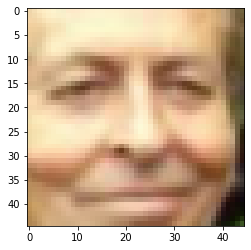

In [236]:
plt.imshow(X_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


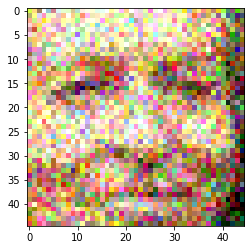

In [239]:
k = get_nois(X_train[0])
plt.imshow(k)

In [244]:
NOISE_TRAIN = []
NOISE_VAL = []
for i in range(TRAIN_SIZE):
  NOISE_TRAIN.append((transforms.ToTensor()(X_train[i]), transforms.ToTensor()(get_nois(X_train[i]))))

for i in range(VAL_SIZE):
  NOISE_VAL.append((transforms.ToTensor()(X_val[i]), transforms.ToTensor()(get_nois(X_val[i]))))


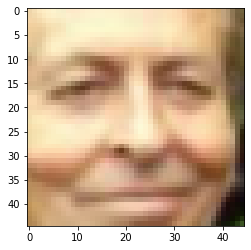

In [245]:
plt.imshow(convert(NOISE_TRAIN[0][0]))

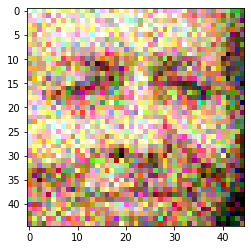

In [246]:
plt.imshow(convert(NOISE_TRAIN[0][1]))

In [247]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr_noise = DataLoader(NOISE_TRAIN, batch_size=batch_size, shuffle=True)
data_val_noise = DataLoader(NOISE_VAL, batch_size=batch_size, shuffle=True)

In [248]:
criterion = nn.MSELoss()

autoencoder_Noise = AutoencoderConv().to(device)

optimizer = torch.optim.Adam(autoencoder_Noise.parameters(), lr=0.001)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.044235,	val Loss: 0.045473 
Epoch: 2 	Training Loss: 0.044235,	val Loss: 0.045472 
Epoch: 3 	Training Loss: 0.044235,	val Loss: 0.045467 
Epoch: 4 	Training Loss: 0.044235,	val Loss: 0.045470 
Epoch: 5 	Training Loss: 0.044235,	val Loss: 0.045470 
Epoch: 6 	Training Loss: 0.044235,	val Loss: 0.045476 
Epoch: 7 	Training Loss: 0.044235,	val Loss: 0.045466 
Epoch: 8 	Training Loss: 0.044235,	val Loss: 0.045473 
Epoch: 9 	Training Loss: 0.044235,	val Loss: 0.045470 
Epoch: 10 	Training Loss: 0.044235,	val Loss: 0.045469 
Epoch: 11 	Training Loss: 0.044235,	val Loss: 0.045480 
Epoch: 12 	Training Loss: 0.044235,	val Loss: 0.045468 
Epoch: 13 	Training Loss: 0.044235,	val Loss: 0.045472 
Epoch: 14 	Training Loss: 0.044235,	val Loss: 0.045472 
Epoch: 15 	Training Loss: 0.044235,	val Loss: 0.045470 
Epoch: 16 	Training Loss: 0.044235,	val Loss: 0.045470 
Epoch: 17 	Training Loss: 0.044235,	val Loss: 0.045473 
Epoch: 18 	Training Loss: 0.044235,	val Loss: 0.045466 
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch: 21 	Training Loss: 0.044235,	val Loss: 0.045476 
Epoch: 22 	Training Loss: 0.044235,	val Loss: 0.045474 
Epoch: 23 	Training Loss: 0.044235,	val Loss: 0.045473 
Epoch: 24 	Training Loss: 0.044235,	val Loss: 0.045468 
Epoch: 25 	Training Loss: 0.044235,	val Loss: 0.045478 
Epoch: 26 	Training Loss: 0.044235,	val Loss: 0.045465 
Epoch: 27 	Training Loss: 0.044235,	val Loss: 0.045470 
Epoch: 28 	Training Loss: 0.044235,	val Loss: 0.045476 
Epoch: 29 	Training Loss: 0.044235,	val Loss: 0.045471 
Epoch: 30 	Training Loss: 0.044235,	val Loss: 0.045473 


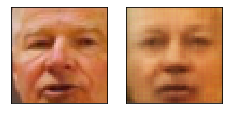

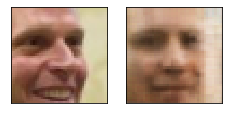

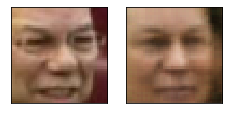

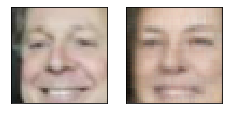

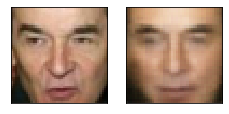

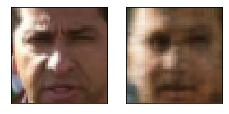

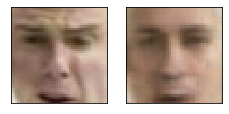

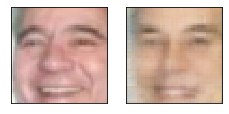

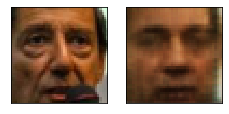

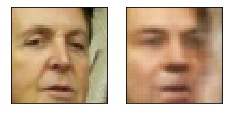

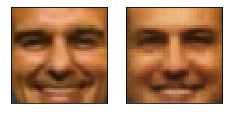

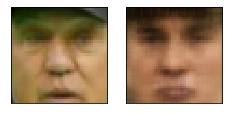

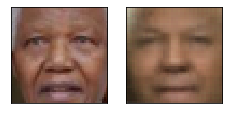

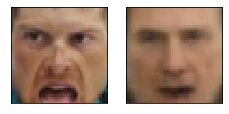

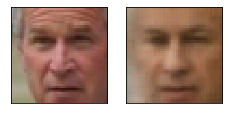

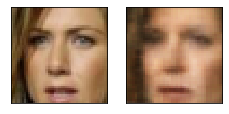

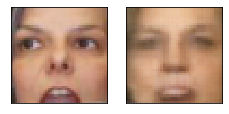

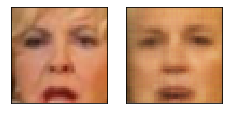

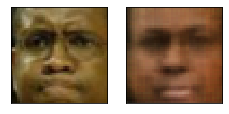

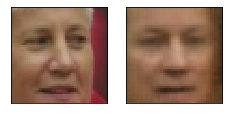

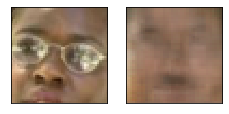

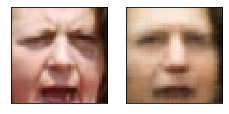

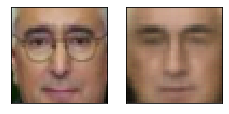

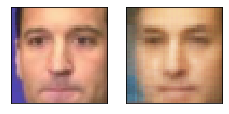

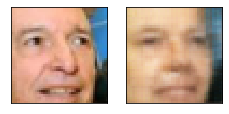

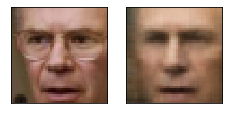

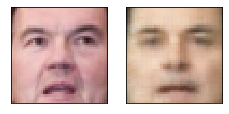

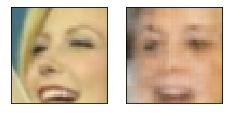

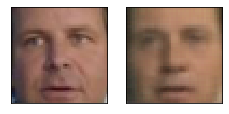

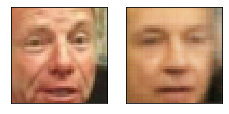

In [271]:
n_epochs = 30
history_train_noise = []
history_val_noise = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    ###################
    # train the model #
    ###################
    for images in data_tr_noise:
        # _ stands in for labels, here
        # no need to flatten images
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images[0].float())
        # calculate the loss
        loss = criterion(reconstruction.float(), images[1].float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.cpu().detach().numpy()
    #plot_gallery([images[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        
    #print avg training statistics 

    train_loss = train_loss/len(data_tr_noise)
    history_train_noise.append(train_loss)
    
    for images in data_val_noise:
        # _ stands in for labels, here
        # no need to flatten images
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images[0].float())
        # calculate the loss
        loss = criterion(reconstruction.float(), images[1].float())
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        val_loss += loss.cpu().detach().numpy()

    val_loss = val_loss/len(data_val)
    history_val_noise.append(val_loss)
    
    plot_gallery([images[0][0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        ))


Дальше я ничего не сделал, можно не смотреть)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
<тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!